In [48]:
import pandas as pd
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, make_scorer, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, FunctionTransformer


In [2]:
involvement_columns = ['Security', 'Humanities', 'Nat. Sci', 'Health', 'AI Ethics', 'Big Data', 
                           'Robotics', 'Documents', 'Multimedia', 'NLP', 'KRR', 'Graphs', 'DL/ML', 
                           'Funding', 'Application-Oriented', 'Number of Members', 
                           'Academic Collaborations', 'System Maturity', 'Demos', 'Industrial Collaborations']

In [3]:
industry_cols = ['Security', 'Humanities', 'Nat. Sci', 'Health', 'AI Ethics', 'Big Data', 'Robotics', 'Documents', 'Multimedia', 'NLP', 'KRR', 'Graphs', 'DL/ML']

In [4]:
comp_cols = ['Number of Members', 'Application-Oriented', 'Academic Collaborations', 
                      'System Maturity', 'Demos', 'Industrial Collaborations']

In [5]:
feature_weights = {
    'Security': 1.0, 'Humanities': 1.0, 'Nat. Sci': 1.0, 'Health': 1.0, 'AI Ethics': 1.0, 'Big Data': 1.0, 'Robotics': 1.0, 
    'Documents': 1.0, 'Multimedia': 1.0, 'NLP': 1.0, 'KRR': 1.0, 'Graphs': 1.0, 'DL/ML': 1.0, 
    'Number of Members': 0.5, 'Application-Oriented': 0.5, 'Academic Collaborations': 0.5, 'System Maturity': 0.5, 
    'Demos': 0.5, 'Industrial Collaborations': 0.5
}

In [8]:
weights = {'Strong': 3, 'Good': 2, 'Average': 1, 'None': 0}

In [26]:
def load_and_preprocess_data(file_path):
    data = pd.read_csv(file_path, index_col=0).transpose()
   
    for column in involvement_columns:
        if column in data.columns:
            data[column] = data[column].map(weights).fillna(0)
    
    return data

In [10]:
def assign_weights(data):
    for column, weight in feature_weights.items():
        if column in data.columns:
            data[column] = data[column]*weight

In [11]:
def reverse_com_values(data):
    max_complementary_value = max(weights.values())
    for column in comp_cols:
        if column in data.columns:
            data[column] = max_complementary_value - data[column]

In [12]:
def plot_elbow_method(X):
    inertia = []
    K = range(1, 11)
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        inertia.append(kmeans.inertia_)
    
    plt.figure(figsize=(10, 6))
    plt.plot(K, inertia, 'bx-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal Number of Clusters')
    plt.show()

    optimal_clusters = 1
    for i in range(1, len(inertia) - 1):
        if inertia[i-1] - inertia[i] < inertia[i] - inertia[i+1]:
            optimal_clusters = i + 1
            break

    return optimal_clusters

In [56]:
# Path to the CSV file
from sklearn.preprocessing import StandardScaler 
filepath = 'data/synthetic_data.csv'

# Load and preprocess the data
dfs = load_and_preprocess_data(filepath)

reverse_com_values(dfs)


In [57]:
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(dfs), columns=dfs.columns, index=dfs.index)

In [58]:
dfs.head()

Field,Security,Humanities,Nat. Sci,Health,AI Ethics,Big Data,Robotics,Documents,Multimedia,NLP,KRR,Graphs,DL/ML,Funding,Application-Oriented,Number of Members,Academic Collaborations,System Maturity,Demos,Industrial Collaborations
"Hall, Nelson and Parks",0.0,3.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,2.0,2.0,1.0,0,0.0,0.0,0.0,2.0
Krueger LLC,1.0,0.0,2.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,1,0.0,1.0,1.0,2.0
Lewis Ltd,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,0.0,1.0,0,0.0,0.0,0.0,0.0
Simpson Group,0.0,0.0,2.0,0.0,0.0,3.0,0.0,2.0,0.0,2.0,0.0,0.0,3.0,0.0,1.0,1,0.0,3.0,2.0,3.0
"Campbell, Gonzalez and Perez",3.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,1.0,0.0,2.0,3.0,0.0,1,0.0,1.0,2.0,2.0


In [29]:
!pip install tensorflow
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

Tensorflow Keras Encoding Analysis

In [59]:
input_dim = df_scaled.shape[1]
encoding_dim = 10 #Number of features in encoded representation

"""
Defines the input layer for the autoencoder.

This layer accepts input data with dimensions equal to the number of features in the dataset (input_dim).
"""

input_layer = Input(shape=(input_dim,))
"""
Defines the encoder part of the autoencoder.

The encoder layer reduces the dimensionality of the input data to the encoding_dim.
It uses the ReLU (Rectified Linear Unit) activation function to introduce non-linearity.
"""

encoder = Dense(encoding_dim, activation="relu")(input_layer)

"""
Defines the decoder part of the autoencoder.

The decoder layer reconstructs the input data from the encoded representation.
It uses the sigmoid activation function to ensure the output values are between 0 and 1, which is useful for normalized data.
"""
decoder = Dense(input_dim, activation="sigmoid")(encoder)

"""
Combines the encoder and decoder into an autoencoder model.

The autoencoder model is built by specifying the input layer and the output layer (decoder output).
"""

autoencoder = Model(inputs=input_layer, outputs=decoder)

"""
Compiles the autoencoder model.

The model is compiled using the Adam optimizer and the mean squared error loss function.
The Adam optimizer is chosen for its efficiency in handling large datasets and its adaptive learning rate.
The mean squared error loss function measures the reconstruction error between the input data and the decoded output.
"""
autoencoder.compile(optimizer=Adam(), loss='mean_squared_error')




In [60]:
"""
Trains the autoencoder model.

The model is trained to reconstruct the input data by minimizing the mean squared error between the input and the decoded output.

Parameters:
- x: The input data to train the autoencoder. In this case, it is 'dfs', the DataFrame containing the scaled features.
- y: The target data for training, which is the same as the input data because the autoencoder learns to reconstruct the input.
- epochs: The number of epochs to train the model. An epoch is one complete pass through the entire training dataset.
- batch_size: The number of samples per gradient update. The model will be trained in mini-batches of this size.
- shuffle: A boolean indicating whether to shuffle the training data before each epoch. Shuffling helps improve the model's generalization by reducing the chance that the model will learn the order of the training data.
- verbose: The verbosity mode. If 0, silent; 1, progress bar; 2, one line per epoch.

Returns:
- A History object. Its History.history attribute is a record of training loss values and metrics values at successive epochs.
"""
autoencoder.fit(df_scaled, df_scaled, epochs=50, batch_size=32, shuffle=True, verbose=2)

Epoch 1/50
32/32 - 0s - 11ms/step - loss: 1.2724
Epoch 2/50
32/32 - 0s - 674us/step - loss: 1.2285
Epoch 3/50
32/32 - 0s - 741us/step - loss: 1.1888
Epoch 4/50
32/32 - 0s - 644us/step - loss: 1.1520
Epoch 5/50
32/32 - 0s - 590us/step - loss: 1.1170
Epoch 6/50
32/32 - 0s - 559us/step - loss: 1.0836
Epoch 7/50
32/32 - 0s - 599us/step - loss: 1.0525
Epoch 8/50
32/32 - 0s - 940us/step - loss: 1.0236
Epoch 9/50
32/32 - 0s - 632us/step - loss: 0.9974
Epoch 10/50
32/32 - 0s - 622us/step - loss: 0.9739
Epoch 11/50
32/32 - 0s - 591us/step - loss: 0.9533
Epoch 12/50
32/32 - 0s - 583us/step - loss: 0.9352
Epoch 13/50
32/32 - 0s - 577us/step - loss: 0.9194
Epoch 14/50
32/32 - 0s - 578us/step - loss: 0.9055
Epoch 15/50
32/32 - 0s - 554us/step - loss: 0.8931
Epoch 16/50
32/32 - 0s - 605us/step - loss: 0.8819
Epoch 17/50
32/32 - 0s - 573us/step - loss: 0.8717
Epoch 18/50
32/32 - 0s - 539us/step - loss: 0.8623
Epoch 19/50
32/32 - 0s - 584us/step - loss: 0.8535
Epoch 20/50
32/32 - 0s - 560us/step - los

In [61]:
encoder_model = Model(inputs=input_layer, outputs=encoder)
encoded_data = encoder_model.predict(df_scaled)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 537us/step


In [62]:
encoded_data

array([[5.0057173 , 0.47906125, 2.1242716 , ..., 0.        , 0.5116741 ,
        0.        ],
       [0.        , 0.        , 5.6511717 , ..., 0.        , 0.84024423,
        2.9621315 ],
       [7.056926  , 4.3371778 , 2.27597   , ..., 4.76661   , 0.7229562 ,
        1.8907924 ],
       ...,
       [3.3544323 , 0.37885147, 0.        , ..., 1.1347293 , 0.84115726,
        0.2063595 ],
       [0.42579216, 0.        , 4.4095154 , ..., 4.8763366 , 1.1567998 ,
        2.6773162 ],
       [3.1757605 , 4.0645313 , 0.        , ..., 5.38345   , 0.        ,
        4.1511803 ]], dtype=float32)

In [63]:
def apply_agglomerative_clustering(encoded_data, n_clusters):
    clustering = AgglomerativeClustering(n_clusters=n_clusters)
    labels = clustering.fit_predict(encoded_data)
    return labels

def apply_kmeans_clustering(encoded_data, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
    kmeans.fit(encoded_data)
    labels = kmeans.labels_
    return labels

def apply_dbscan_clustering(encoded_data, eps, min_samples):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(encoded_data)
    return labels

In [64]:
silhouette_avg_scores = []
for n_clusters in range(2, 11):
    labels = apply_kmeans_clustering(encoded_data, n_clusters)
    silhouette_avg = silhouette_score(encoded_data, labels)
    silhouette_avg_scores.append(silhouette_avg)

optimal_clusters_kmeans = silhouette_avg_scores.index(max(silhouette_avg_scores)) + 2
print(f'Optimal number of clusters for KMeans: {optimal_clusters_kmeans}')

Optimal number of clusters for KMeans: 5


In [65]:
best_labels_kmeans = apply_kmeans_clustering(encoded_data, optimal_clusters_kmeans)

In [66]:
silhouette_avg_kmeans = silhouette_score(encoded_data, best_labels_kmeans)
davies_bouldin_kmeans = davies_bouldin_score(encoded_data, best_labels_kmeans)
print(f'KMeans - Silhouette Score: {silhouette_avg_kmeans}, Davies-Bouldin Score: {davies_bouldin_kmeans}')

KMeans - Silhouette Score: 0.12567181885242462, Davies-Bouldin Score: 2.0920127163314968


In [67]:
silhouette_avg_scores = []
for n_clusters in range(2, 11):
    labels = apply_agglomerative_clustering(encoded_data, n_clusters)
    silhouette_avg = silhouette_score(encoded_data, labels)
    silhouette_avg_scores.append(silhouette_avg)

optimal_clusters_agg = silhouette_avg_scores.index(max(silhouette_avg_scores)) + 2
print(f'Optimal number of clusters for Agglomerative Clustering: {optimal_clusters_agg}')


Optimal number of clusters for Agglomerative Clustering: 6


In [68]:
best_labels_agg = apply_agglomerative_clustering(encoded_data, optimal_clusters_agg)

In [69]:
silhouette_avg_agg = silhouette_score(encoded_data, best_labels_agg)
davies_bouldin_agg = davies_bouldin_score(encoded_data, best_labels_agg)
print(f'Agglomerative - Silhouette Score: {silhouette_avg_agg}, Davies-Bouldin Score: {davies_bouldin_agg}')

Agglomerative - Silhouette Score: 0.09770204871892929, Davies-Bouldin Score: 2.301646459101517


In [70]:
#Choose the best clustering algorithm
clustering_scores = {
    'KMeans': silhouette_avg_kmeans,
    'Agglomerative': silhouette_avg_agg,
    #'DBSCAN': best_dbscan_score if len(set(best_labels_dbscan)) > 1 else -1
}

best_clustering_method = max(clustering_scores, key=clustering_scores.get)
print(f'Best Clustering Method: {best_clustering_method}')

Best Clustering Method: KMeans


In [72]:
if best_clustering_method == 'KMeans':
    best_labels = best_labels_kmeans
else:
    best_labels = best_labels_agg

In [73]:
df_scaled['Cluster'] = best_labels
cluster_label_series = pd.Series(best_labels)
cluster_counts = cluster_label_series.value_counts().sort_index()
cluster_counts

0    245
1    212
2    280
3     87
4    176
Name: count, dtype: int64

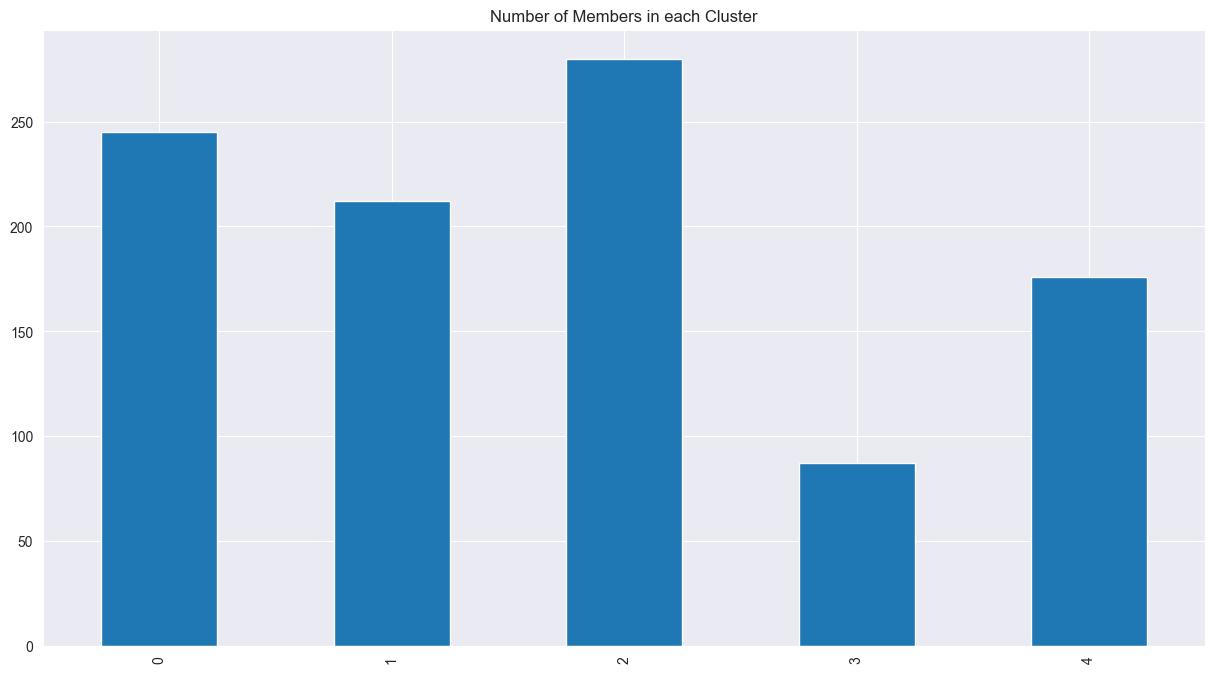

In [74]:
plt.figure(figsize=(15, 8))
cluster_counts.plot(kind='bar', stacked=True, figsize=(15, 8))
plt.title('Number of Members in each Cluster')
plt.show()

In [75]:
# Generate profiles for each cluster
def profile_clusters(df):
    """
    Generates statistical profiles for each cluster.

    This function groups the DataFrame by the 'cluster' column and calculates
    the mean, standard deviation, minimum, and maximum for each feature within
    each cluster.

    Parameters:
    - df (DataFrame): The DataFrame containing the team data, including a 'cluster' column.

    Returns:
    - profiles (DataFrame): A DataFrame with the mean, standard deviation, minimum, and maximum
                            values for each feature within each cluster.
    """
    
    profiles = df.groupby('Cluster').agg(['mean', 'std', 'min', 'max'])
    return profiles

cluster_profiles = profile_clusters(df_scaled)
print("Cluster Profiles:")
print(cluster_profiles)

Cluster Profiles:
Field    Security                               Humanities            \
             mean       std       min       max       mean       std   
Cluster                                                                
0       -0.170435  0.755476 -0.448676  3.269633   0.338182  1.027406   
1        0.591983  1.489053 -0.448676  3.269633  -0.152793  0.949666   
2       -0.187509  0.623341 -0.448676  3.269633  -0.043798  0.983208   
3       -0.192241  0.685099 -0.448676  3.269633   0.099930  1.086032   
4       -0.082479  0.921034 -0.448676  3.269633  -0.266437  0.875498   

Field                        Nat. Sci            ... System Maturity  \
              min       max      mean       std  ...             min   
Cluster                                          ...                   
0       -0.905336  1.977899 -0.227065  0.673021  ...       -1.042366   
1       -0.905336  1.977899 -0.277630  0.613249  ...       -1.042366   
2       -0.905336  1.977899 -0.336699  0.4818

In [76]:
X = df_scaled.drop(columns=['Cluster'])
y = df_scaled['Cluster']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [50]:
X

Field,Security,Humanities,Nat. Sci,Health,AI Ethics,Big Data,Robotics,Documents,Multimedia,NLP,KRR,Graphs,DL/ML,Funding,Application-Oriented,Number of Members,Academic Collaborations,System Maturity,Demos,Industrial Collaborations
"Hall, Nelson and Parks",-0.448676,1.977899,-0.470697,-0.688054,-0.706794,-0.224874,-0.302825,2.124205,-0.539798,-0.723123,-1.325477,-0.586008,0.444830,0.458095,-0.251883,1.343749,1.155235,1.042366,1.202662,-0.154439
Krueger LLC,0.790760,-0.905336,2.940148,-0.688054,-0.706794,-1.079909,3.302236,-0.526633,-0.539798,-0.723123,0.766831,-0.586008,-0.566148,-1.207704,0.848042,0.084378,1.155235,-0.171098,0.029333,-0.154439
Lewis Ltd,-0.448676,-0.905336,-0.470697,-0.688054,-0.706794,-0.224874,-0.302825,-0.526633,-0.539798,1.799400,0.766831,-0.586008,-0.566148,-1.207704,-0.251883,1.343749,1.155235,1.042366,1.202662,1.918574
Simpson Group,-0.448676,-0.905336,2.940148,-0.688054,-0.706794,1.485195,-0.302825,1.240593,-0.539798,0.958559,-1.325477,-0.586008,1.455809,-1.207704,-0.251883,0.084378,1.155235,-2.598027,-1.143995,-1.190946
"Campbell, Gonzalez and Perez",3.269633,-0.905336,1.234726,-0.688054,-0.706794,-0.224874,-0.302825,-0.526633,-0.539798,1.799400,-0.279323,-0.586008,0.444830,1.290994,0.848042,0.084378,1.155235,-0.171098,-1.143995,-0.154439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Hill and Sons,-0.448676,-0.905336,-0.470697,-0.688054,-0.706794,1.485195,-0.302825,2.124205,-0.539798,-0.723123,-0.279323,-0.586008,-0.566148,-1.207704,-1.351808,-1.174993,1.155235,1.042366,-1.143995,-0.154439
"Anderson, Thomas and Miller",-0.448676,-0.905336,-0.470697,-0.688054,-0.706794,0.630161,-0.302825,-0.526633,-0.539798,0.958559,-1.325477,-0.586008,-1.577126,0.458095,-2.451733,-1.174993,1.155235,-0.171098,0.029333,-1.190946
Williams PLC,-0.448676,-0.905336,-0.470697,-0.688054,1.175481,-1.079909,-0.302825,1.240593,-0.539798,-0.723123,0.766831,-0.586008,0.444830,1.290994,0.848042,-1.174993,1.155235,-0.171098,0.029333,-0.154439
Williams-Beard,-0.448676,-0.905336,-0.470697,1.040725,1.175481,-1.079909,-0.302825,-0.526633,-0.539798,-0.723123,0.766831,1.434709,1.455809,-0.374805,0.848042,0.084378,1.155235,-0.171098,-1.143995,0.882067


In [77]:
class QualitativeToQuantitativeTransformer(BaseEstimator, TransformerMixin):
    
    """
    A custom transformer to map qualitative descriptions to quantitative values.

    Parameters:
    - columns (list of str): List of column names to be transformed.
    - mapping (dict): A dictionary mapping qualitative descriptions to quantitative values.

    Methods:
    - fit(X, y=None): Fits the transformer on the dataset. (No action needed for this transformer)
    - transform(X): Transforms the specified columns in the dataset using the provided mapping.
    """
     
    def __init__(self, columns, mapping):
        self.columns = columns
        self.mapping = mapping
        
    def fit(self, X, y=None):
        """
        Fit the transformer. This transformer doesn't need to learn anything, so fit does nothing.
        
        Parameters:
        - X (DataFrame): Input data.
        - y (Series or None): Target data (not used).
        
        Returns:
        - self: Fitted transformer.
        """
        return self
    
    def transform(self, X):
        """
        Transform the specified columns using the provided mapping.
        
        Parameters:
        - X (DataFrame): Input data.
        
        Returns:
        - X_transformed (DataFrame): Transformed data with specified columns mapped to quantitative values.
        """
        X_transformed = X.copy()
        for column in self.columns:
            if column in X_transformed.columns:
                X_transformed[column] = X_transformed[column].map(self.mapping).fillna(0)
        return X_transformed

weights = {'Strong': 3, 'Good': 2, 'Average': 1, 'None': 0}

preprocessor = ColumnTransformer(
    transformers=[
        ('qualitative', QualitativeToQuantitativeTransformer(involvement_columns, weights), involvement_columns),
        ('scaler', StandardScaler(), involvement_columns + comp_cols)
    ],
)



In [78]:
from sklearn.ensemble import RandomForestClassifier

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])


In [53]:
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': [None, 'sqrt', 'log2']  
}


In [79]:
# Perform hyperparameter optimization using GridSearchCV
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

best_pipeline = grid_search.best_estimator_

train_score = best_pipeline.score(X_train, y_train)
test_score = best_pipeline.score(X_test, y_test)

y_pred = best_pipeline.predict(X_test)

print(f"Optimized Train Accuracy: {train_score}")
print(f"Optimized Test Accuracy: {test_score}")
print("Optimized Classification Report:\n", classification_report(y_test, y_pred))
print("Optimized Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Fitting 3 folds for each of 243 candidates, totalling 729 fits
[CV] END classifier__max_depth=10, classifier__max_features=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=200; total time=   0.8s
[CV] END classifier__max_depth=10, classifier__max_features=None, classifier__min_samples_leaf=1, classifier__min_samples_split=5, classifier__n_estimators=200; total time=   0.5s
[CV] END classifier__max_depth=10, classifier__max_features=None, classifier__min_samples_leaf=1, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   0.2s
[CV] END classifier__max_depth=10, classifier__max_features=None, classifier__min_samples_leaf=1, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   0.7s
[CV] END classifier__max_depth=10, classifier__max_features=None, classifier__min_samples_leaf=2, classifier__min_samples_split=5, classifier__n_estimators=100; total time=   0.5s
[CV] END classifier__max_depth=10, 